# SIFT from scratch

In [1]:
print("SIFT from scratch")

SIFT from scratch


In [9]:
import logging

import cv2
import numpy
from numpy import linalg
from matplotlib import pyplot

In [5]:
logger = logging.getLogger(__name__)

In [6]:
float_tolerance = 1e-7

In [ ]:
def generate_base_image(image: numpy.ndarray, sigma: float, assumed_blur: float) -> numpy.ndarray:
    """Generate base image from input image by upsampling by 2 in both directions and blurring"""
    logging.debug("Generateing base image...")

    image = cv2.resize(image, (0, 0), fx=2, fy=2, interpolation=cv2.INTER_LINEAR)
    sigma_diff = numpy.sqrt(max((sigma ** 2) - ((2 * assumed_blur) ** 2), 0.01))
    return cv2.GaussianBlur(image, (0, 0), sigmaX=sigma_diff, sigmaY=sigma_diff) # the image blur is sigma instead of assumed_blur

def compute_number_of_octaves(image_shape: tuple[int, int]) -> int:
    """Compute number of octaves in image pyramid as function of base image shape (OpenCV default)"""
    return int(numpy.round(numpy.log(min(image_shape)) / numpy.log(2) - 1))

def generate_gaussian_kernels(sigma: float, num_intervals: int) -> list[float]:
    """Generate list of gaussisan kernels at which to blur the input image. Default values of sigma, intervals, and octaves follow section 3 of Lowe's paper"""
    logger.debug("Generating scales...")
    num_images_per_octave = num_intervals + 3
    k = 2 ** (1. / num_intervals)
    # scale of gaussian blur necessary to go from one blur to the next within an octave
    gaussian_kernels = numpy.zeros(num_images_per_octave) 
    gaussian_kernels[0] = sigma

    for image_index in range(1, num_images_per_octave):
        sigma_previous = (k ** (image_index - 1)) * sigma
        sigma_total = k * sigma_previous
        gaussian_kernels[image_index] = numpy.sqrt(sigma_total ** 2 - sigma_previous ** 2)
    
    return gaussian_kernels

def generate_gaussian_images(image: numpy.ndarray, num_octaves: int, gaussian_kernels: list[float]) -> list[list[numpy.ndarray]]:
    """Generate scale-space pyramid of gaussian images"""
    logger.debug("Generating Gaussian images...")
    gaussian_images = []

    for octave_index in range(num_octaves):
        gaussian_images_in_octave = []
        gaussian_images_in_octave.append(image) # first image in octave already has the correct blur
        for gaussian_kernel in gaussian_kernels[1:]:
            image = cv2.GaussianBlur(image, (0, 0), sigmaX=gaussian_kernel, sigmaY=gaussian_kernel)
            gaussian_images_in_octave.append(image)
        gaussian_images.append(gaussian_images_in_octave)
        octave_base = gaussian_images_in_octave[-3]
        image = cv2.resize(octave_base, (int(octave_base.shape[1] / 2), int(octave_base.shape[0] / 2)), interpolation=cv2.INTER_NEAREST)
    
    return gaussian_images

def generate_dog_images(gaussian_images: list[list[numpy.ndarray]]) -> list[list[numpy.ndarray]]:
    """Generate Difference of Gaussian (DOG) image pyramid"""
    logger.debug("Generating Difference of Gaussian (DOG) images...")
    dog_images = []

    for gaussian_images_in_octave in gaussian_images:
        dog_images_in_octave = []
        for first_image, second_image in zip(gaussian_images_in_octave, gaussian_images_in_octave[1:]):
            dog_images_in_octave.append(numpy.subtract(second_image, first_image)) # ordinary subtraction will not work because images are unsigned integers
        dog_images.append(dog_images_in_octave)
    
    return dog_images

def is_pixel_an_extremum(first_subimage: numpy.ndarray, second_subimage: numpy.ndarray, third_subimage: numpy.ndarray, threshold: float):
    """Return True if the center element of the 3x3x3 input array is strictly greater that or less than all its neighbors, False otherwise"""
    center_pixel_value: float = second_subimage[1, 1]
    if abs(center_pixel_value) > threshold:
        if center_pixel_value > 0:
            return numpy.all(center_pixel_value >= first_subimage) and \
                numpy.all(center_pixel_value >= third_subimage) and \
                numpy.all(center_pixel_value >= second_subimage[0, :]) and \
                numpy.all(center_pixel_value >= second_subimage[2, :]) and \
                center_pixel_value >= second_subimage[1, 0] and \
                center_pixel_value >= second_subimage[1, 2]
        elif center_pixel_value < 0:
            return numpy.all(center_pixel_value <= first_subimage) and \
                numpy.all(center_pixel_value <= third_subimage) and \
                numpy.all(center_pixel_value <= second_subimage[0, :]) and \
                numpy.all(center_pixel_value <= second_subimage[2, :]) and \
                center_pixel_value <= second_subimage[1, 0] and \
                center_pixel_value <= second_subimage[1, 2]
    
    return False

def localize_extremum_via_quadratic_fit(i, j, image_index, octave_index, num_intervals, dog_images_in_octave, sigma, contrast_threshold, image_border_width, eigen_value_ratio=10, num_attempts_until_convergence=5):
    """Iteratively refine pixel positions of scale-space extrema via quadratic fit around each extremum's neighbours"""

def find_scale_space_extrema(gaussian_images: list[list[numpy.ndarray]], dog_images: list[list[numpy.ndarray]], num_intervals: int, sigma: float, image_border_width: int, contrast_threshold: float = 0.04):
    """Find pixel positions of all scale-space extrema in the image pyramid"""
    logger.debug("Finding scale-space extrema...")
    threshold = numpy.floor(0.5 * contrast_threshold / num_intervals * 255) # from OpenCV implementation
    keypoints = []

    for octave_index, dog_images_in_octave in enumerate(dog_images):
        for image_index, (first_image, second_image, third_image) in enumerate(zip(dog_images_in_octave, dog_images_in_octave[1:], dog_images_in_octave[2:])):
            # (i, j) is the center of the 3x3 array
            for i in range(image_border_width, first_image.shape[0] - image_border_width):
                for j in range(image_border_width, first_image.shape[1] - image_border_width):
                    if is_pixel_an_extremum(first_image[i - 1:i + 2, j - 1: j + 2], second_image[i - 1: i + 2; j - 1: j + 2], third_image[i - 1: i + 2; j - 1: j + 2], threshold):
                    localization_result = localizati

## Step by step

input_img shape:  (223, 324)


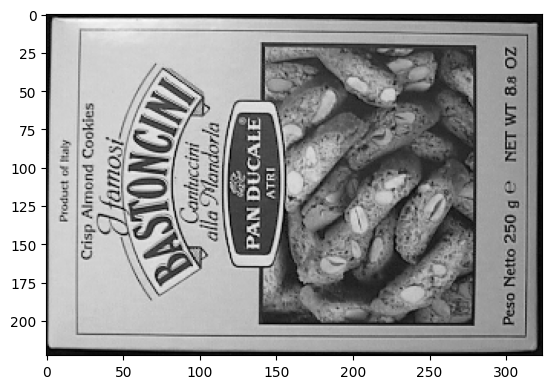

In [ ]:
input_img = (cv2.imread("images/box.png", 0) / 255).astype("float32")
print("input_img shape: ", input_img.shape)
pyplot.imshow(input_img, cmap="gray")
pyplot.show()

# print(input_img / 255)

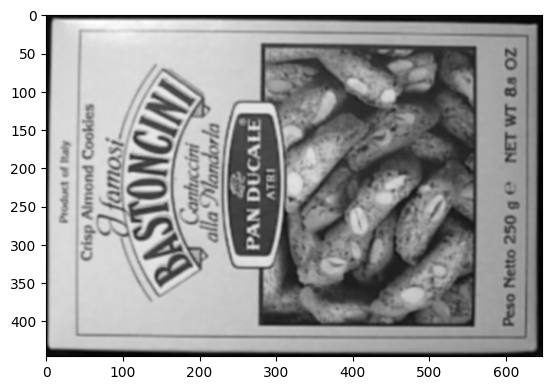

In [22]:
base_img = generate_base_image(input_img, 1.6, 0.5)
pyplot.imshow(base_img, cmap="gray")
pyplot.show()

In [23]:
num_octaves = compute_number_of_octaves(base_img.shape)
print(num_octaves)

8


In [25]:
gaussian_kernels = generate_gaussian_kernels(1.6, 3)
print(gaussian_kernels)

[1.6        1.2262735  1.54500779 1.94658784 2.452547   3.09001559]


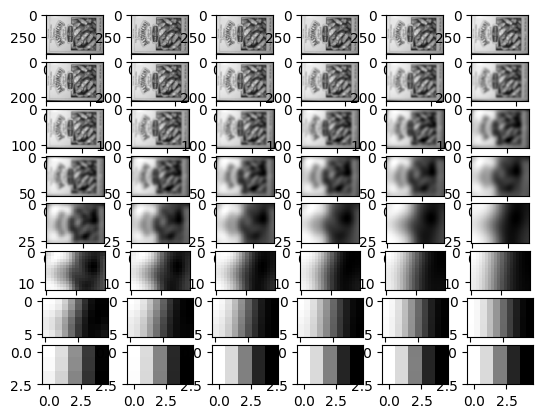

In [40]:
gaussian_images = generate_gaussian_images(base_img, num_octaves, gaussian_kernels)

_, axes = pyplot.subplots(len(gaussian_images), len(gaussian_kernels))
for i, octave in enumerate(gaussian_images):
    for j, img in enumerate(octave):
        axes[i][j].imshow(img, cmap="gray")
pyplot.show()

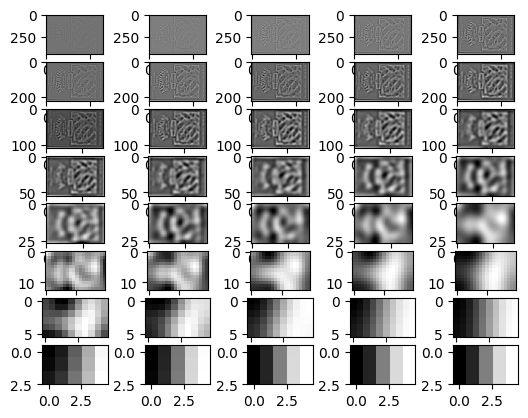

In [41]:
dog_images = generate_dog_images(gaussian_images)

_, axes = pyplot.subplots(len(dog_images), len(gaussian_kernels) - 1)
for i, octave in enumerate(dog_images):
    for j, img in enumerate(octave):
        axes[i][j].imshow(img, cmap="gray")

pyplot.show()

## Compute SIFT keypoints and descriptors

In [ ]:
def compute_keypoints_and_descriptors(image, sigma=1.6, num_intervals=3, assumed_blur=0.5, image_border_width=5):
    """Compute SIFT keypoints and descriptors for an input image"""
    image = image.astype('float32')